# Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a type of deep learning framework that have revolutionized the field of generative modeling. GANs consist of two main components: a generator network and a discriminator network. The objective of GANs is to train the generator network to produce realistic synthetic data that is indistinguishable from real data, while the discriminator network aims to distinguish between the generated and real data.

The generator network takes random noise as input and generates synthetic data samples. Initially, the generated samples may not resemble the real data. The discriminator network, on the other hand, is trained to distinguish between the generated samples and real data samples. It tries to classify whether a given sample is real or fake. The generator and discriminator networks are trained iteratively in a competitive manner, playing a min-max game.

During training, the generator tries to improve its ability to generate realistic samples that can fool the discriminator, while the discriminator tries to become more accurate in distinguishing between real and fake samples. This adversarial game between the generator and discriminator leads to a dynamic equilibrium, where the generator progressively generates more realistic samples and the discriminator becomes more discerning.

The ultimate goal of GANs is to train the generator network to produce synthetic samples that are so close to real data that even the discriminator cannot distinguish them. This is achieved by updating the generator and discriminator networks alternately using gradient-based optimization techniques.

GANs have gained popularity due to their ability to generate highly realistic and diverse data, including images, videos, and even text. They have been used for various applications such as image synthesis, data augmentation, style transfer, and image-to-image translation.

 GANs can be thought of as a **game** between two competing networks. The generator network learns to produce realistic synthetic data to fool the discriminator, while the discriminator network aims to accurately distinguish between real and fake samples. This adversarial game drives the GAN training process and leads to the generation of high-quality synthetic data.


Epoch [1/50], Step [100/469], Generator Loss: 2.6834, Discriminator Loss: 0.1132
Epoch [1/50], Step [200/469], Generator Loss: 5.0509, Discriminator Loss: 0.0105
Epoch [1/50], Step [300/469], Generator Loss: 3.4948, Discriminator Loss: 0.1870
Epoch [1/50], Step [400/469], Generator Loss: 4.6189, Discriminator Loss: 0.1960
Epoch [2/50], Step [100/469], Generator Loss: 8.6057, Discriminator Loss: 0.0448
Epoch [2/50], Step [200/469], Generator Loss: 4.1978, Discriminator Loss: 0.0659
Epoch [2/50], Step [300/469], Generator Loss: 3.4050, Discriminator Loss: 0.0631
Epoch [2/50], Step [400/469], Generator Loss: 4.3219, Discriminator Loss: 0.0683
Epoch [3/50], Step [100/469], Generator Loss: 5.8372, Discriminator Loss: 0.0618
Epoch [3/50], Step [200/469], Generator Loss: 1.5942, Discriminator Loss: 0.4668
Epoch [3/50], Step [300/469], Generator Loss: 3.9848, Discriminator Loss: 0.0507
Epoch [3/50], Step [400/469], Generator Loss: 3.5677, Discriminator Loss: 0.4104
Epoch [4/50], Step [100/469]

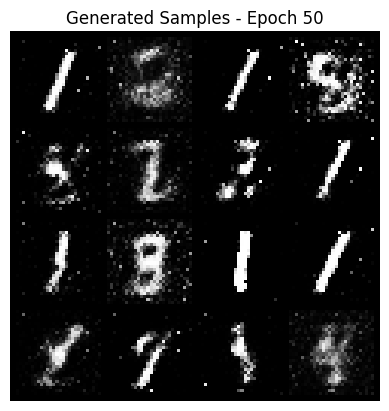

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
latent_size = 100
num_epochs = 50
learning_rate = 0.0002

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

# Generator network
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.activation = nn.ReLU()
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x))
        return x

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.activation = nn.LeakyReLU(0.2)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x))
        return x

# Create the generator and discriminator
generator = Generator(latent_size).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    fake_samples = generator(z).reshape(-1, 1, 28, 28)
    fake_samples = (fake_samples + 1) / 2  # Rescale to [0, 1] for visualization

# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()


# Game Theory and GANS

Game theory is a mathematical framework that studies how individuals or entities interact strategically in situations where the outcome of their decisions depends not only on their own actions but also on the actions of others. It provides a powerful tool to analyze and predict the behavior and outcomes of strategic interactions.

One of the fundamental concepts in game theory is the game itself, which consists of players, strategies, and payoffs. Players are the decision-makers in the game, and they choose from a set of strategies to determine their actions. The payoffs represent the outcomes or rewards associated with each combination of strategies chosen by the players.

There are different types of games, such as cooperative games, non-cooperative games, simultaneous games, and sequential games. In cooperative games, players form coalitions and work together to achieve common goals. Non-cooperative games, on the other hand, involve players making decisions independently and without explicit communication or cooperation.

To illustrate game theory, let's consider the classic example of the Prisoner's Dilemma. Two individuals are arrested for a crime, and they are held in separate cells. The prosecutor offers each prisoner a deal: if one stays silent (cooperates) and the other confesses (defects), the defector will receive a reduced sentence, while the cooperator will face a harsher penalty. If both prisoners confess, they both receive moderate sentences. If both stay silent, they both receive lighter sentences.

In this game, the players (prisoners) have two strategies: cooperate (stay silent) or defect (confess). The payoffs could be represented by the length of their prison sentences. Each player's payoff depends on their own strategy as well as the strategy chosen by the other player. The game theory analysis reveals that, despite the potential for cooperation leading to a better outcome for both players, the dominant strategy for each player is to defect. This demonstrates the tension between individual rationality and collective welfare in strategic interactions.

Now, let's connect game theory to Generative Adversarial Networks (GANs). GANs can be seen as a game between the generator and discriminator networks. The generator's goal is to produce synthetic data that resembles the real data, while the discriminator aims to distinguish between real and generated data. This adversarial game between the two networks creates a dynamic equilibrium, where the generator learns to generate increasingly realistic samples, and the discriminator becomes more skilled at distinguishing between real and fake data.

In this game-theoretic setting, the generator and discriminator update their strategies (network parameters) iteratively based on the outcomes (classification accuracy) and the anticipated strategies of their opponents. The generator aims to minimize the discriminator's ability to differentiate between real and fake samples, while the discriminator aims to maximize its accuracy. This competitive process drives the training of GANs and leads to the generation of high-quality synthetic data.


# Conv Gans

Generator:
The generator in a GAN is like a skilled forger who tries to create realistic counterfeit artworks. It takes as input a random noise vector (latent space) and tries to generate data that resembles the real data. The generator uses a series of transformations and learned parameters to convert the random noise into meaningful output. Over time, the generator learns to produce data that becomes indistinguishable from the real data, fooling the discriminator.

Discriminator:
The discriminator in a GAN is like an expert art critic who is trained to differentiate between real artworks and the counterfeit ones created by the generator. Its role is to assess the authenticity of the generated data by distinguishing it from the real data. The discriminator is a binary classifier that receives input data and outputs a probability indicating whether the input is real or fake. It learns to become more accurate in identifying the generated data as the training progresses.

Training Process:
During the training process, the generator and discriminator engage in a competitive game. The generator aims to generate data that the discriminator cannot distinguish from real data, while the discriminator aims to correctly classify the real and generated data. As the generator gets better at creating realistic data, the discriminator is continuously challenged to improve its ability to differentiate between real and fake data.

The interaction between the generator and discriminator creates a feedback loop. The generator learns to generate more realistic data by receiving feedback from the discriminator, which helps it improve its output. Similarly, the discriminator learns to become more accurate in distinguishing between real and fake data by continuously facing more challenging generated data from the generator.

Through this adversarial process, the generator and discriminator improve iteratively, and ideally, the generator learns to generate data that is indistinguishable from the real data, leading to the creation of high-quality synthetic data.

Overall, the generator and discriminator work together in a GAN to achieve the ultimate goal of generating realistic data that resembles the real-world distribution.






In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
batch_size = 128
num_epochs = 100

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, self.latent_dim, 1, 1)
        return self.model(x)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, kernel_size=7, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)




# Training loop
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        batch_size = images.size(0)

        # Create labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # === Train Discriminator ===
        disc_optimizer.zero_grad()

        # Compute discriminator loss on real data
        real_output = discriminator(images)
        real_labels = torch.ones_like(real_output)  # Reshape real_labels
        real_loss = criterion(real_output, real_labels)

        # Generate fake data
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_images = generator(z)

        # Compute discriminator loss on fake data
        fake_output = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_output)  # Reshape fake_labels
        fake_loss = criterion(fake_output, fake_labels)

        # Compute total discriminator loss and backpropagate
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # === Train Generator ===
        gen_optimizer.zero_grad()

        # Generate fake data
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_images = generator(z)

        # Compute generator loss
        outputs = discriminator(fake_images)
        gen_loss = criterion(outputs, real_labels)

        # Backpropagate and update generator weights
        gen_loss.backward()
        gen_optimizer.step()

        # Print training progress
        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], "
                  f"Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}")

# Generate and display a sample of generated images
num_samples = 25
z = torch.randn(num_samples, 100, 1, 1).to(device)
generated_images = generator(z).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_samples):
    img = generated_images[i].squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
